In [1]:
# lib
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
# def

# config

num_positions = 500
d_model = 512

def cosine_similarity(vec1, vec2):
    vec1_norm = np.linalg.norm(vec1) + 0.00000000001
    vec2_norm = np.linalg.norm(vec2) + 0.00000000001
    return np.dot(vec1, vec2) / (vec1_norm * vec2_norm)
def cosine_similarity_matrix(vectors):
    return np.array([[cosine_similarity(vec1, vec2) for vec2 in vectors] for vec1 in vectors])


def plot(x, title=''):
  plt.figure(figsize=(7,4))
  plt.pcolormesh(x,
                # Use a diverging colormap so it's clear where zero is.
                cmap='RdBu', vmin=-1, vmax=1)
  plt.xlim([0,d_model])
  plt.ylabel('num_positions')
  plt.xlabel('d_model')
  plt.title(title)

  plt.colorbar()

def plot_similarity(x, title):
  similarity_matrix = cosine_similarity_matrix(x)
  plt.figure(figsize=(5,4))
  plt.pcolormesh(similarity_matrix,
                # Use a diverging colormap so it's clear where zero is.
                cmap='RdBu', vmin=-1, vmax=1)
  plt.xlim([0,num_positions])
  plt.ylabel(num_positions)
  plt.xlabel(num_positions)
  plt.title(f'plot_similarity {title}')
  plt.colorbar()

def make_circle():
  x = np.arange(0, d_model)
  y = np.arange(0, num_positions)
  arr = np.zeros((y.size, x.size))
  cx = d_model / 2.
  cy = num_positions / 2.
  r = num_positions / 2.
  mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
  arr[mask] = 1.
  return arr


In [3]:

# origin_x = 2 * np.random.rand(num_positions, d_model) - 1
# origin_x = np.random.rand(num_positions, d_model) - np.random.rand(num_positions, d_model)
# origin_x = np.ones((num_positions, d_model))
origin_x = make_circle()

print(origin_x, origin_x.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (500, 512)


1.  position ecoding



\begin{align*}
    PE_{(pos,2i)} = sin(pos / 10000^{2i/dmodel}) \\
    PE_{(pos,2i+1)} = cos(pos / 10000^{2i/dmodel})
\end{align*}

In [4]:
i_s = np.arange(d_model//2)
# print(i_s)
min_rate = 1/10000
exponents = (2 / d_model) * i_s # [0, 1]
# print(exponents)
omegas = min_rate**exponents # [1, 0.0001]
omegas = omegas[np.newaxis, :]
# print(omegas, omegas.shape)


In [5]:
positions = np.arange(num_positions)
positions = positions[:, np.newaxis]
# print(positions, positions.shape)
# print((positions/omegas))
sines = np.sin(positions*omegas)
cosines = np.cos(positions*omegas)
# print(sines)
# print(cosines)
pos_encoding = np.concatenate([sines, cosines], axis=-1)
pos_encoding_ziped = np.reshape(np.stack((sines, cosines), axis=-1), (num_positions, d_model))



# print(pos_encoding, pos_encoding.shape)

In [6]:
xs_positioned = pos_encoding + origin_x
xs_positioned_ziped = pos_encoding_ziped + origin_x


origin_x norm [ 0.          6.70820393  7.93725393  8.77496439  9.43398113  9.94987437
 10.44030651 10.81665383 11.18033989 11.53256259 11.78982612 12.12435565
 12.36931688 12.60952021 12.84523258 13.07669683 13.22875656 13.45362405
 13.67479433 13.82027496 13.96424004 14.17744688 14.31782106 14.45683229
 14.59451952 14.73091986 14.93318452 15.06651917 15.13274595 15.26433752
 15.39480432 15.5241747  15.65247584 15.77973384 15.84297952 15.96871942
 16.09347694 16.15549442 16.2788206  16.40121947 16.46207763 16.58312395
 16.64331698 16.76305461 16.82260384 16.94107435 17.         17.05872211
 17.17556404 17.23368794 17.29161647 17.40689519 17.4642492  17.52141547
 17.63519209 17.69180601 17.74823935 17.80449381 17.91647287 17.97220076
 18.02775638 18.08314132 18.13835715 18.1934054  18.30300522 18.35755975
 18.41195264 18.46618531 18.52025918 18.57417562 18.62793601 18.68154169
 18.734994   18.78829423 18.84144368 18.89444363 18.94729532 19.
 19.05255888 19.10497317 19.15724406 19.20937

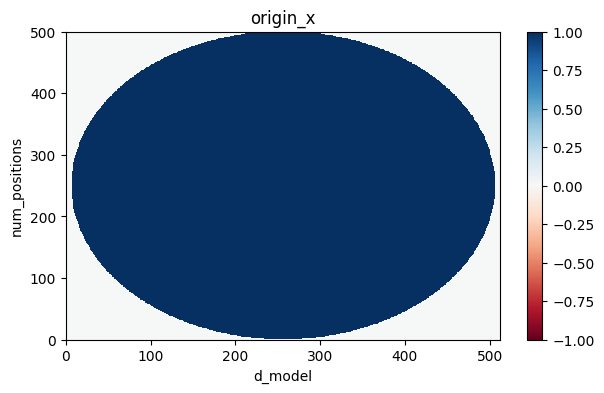

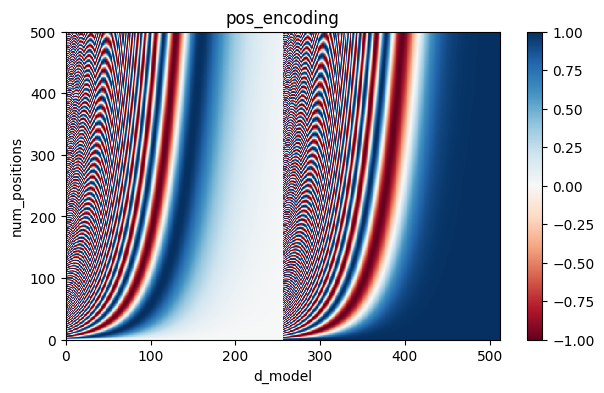

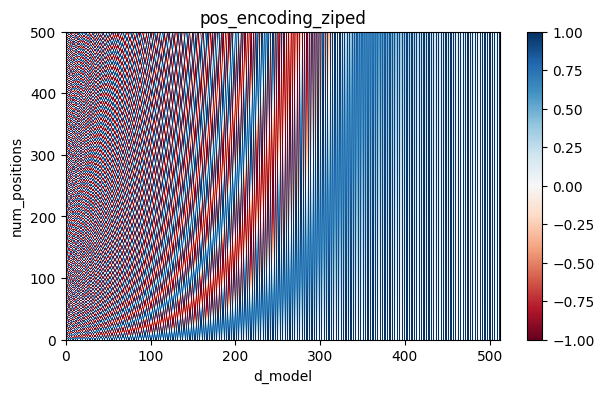

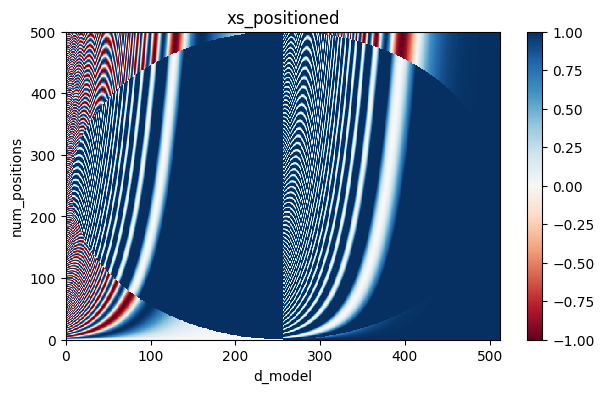

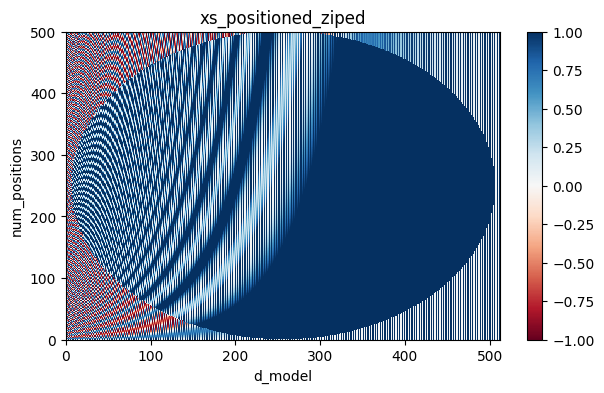

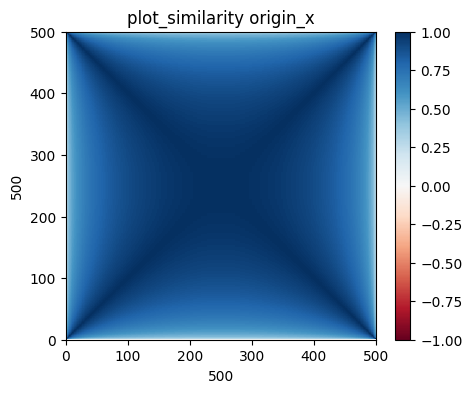

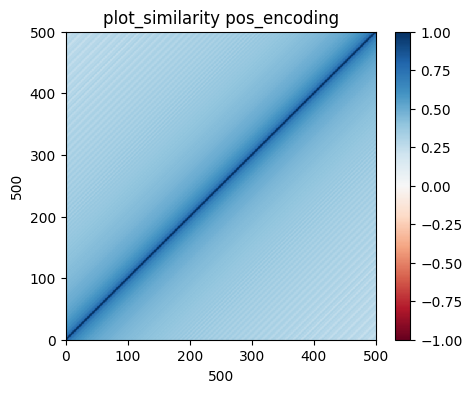

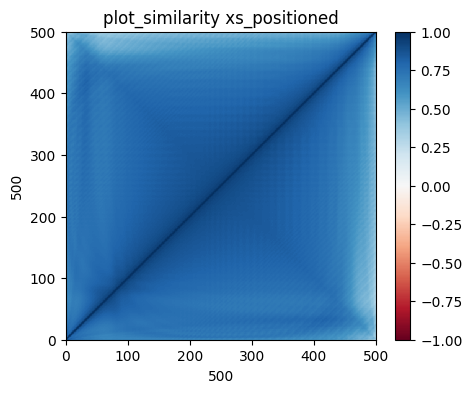

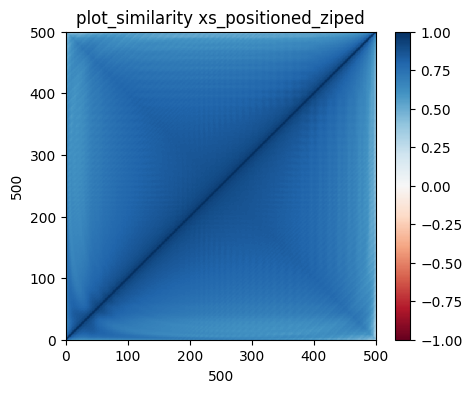

In [7]:
print('origin_x norm', np.linalg.norm(origin_x,axis=1))
print('origin_x xs_positioned', np.linalg.norm(xs_positioned,axis=1))

plot(origin_x, 'origin_x')
plot(pos_encoding, 'pos_encoding')
plot(pos_encoding_ziped, 'pos_encoding_ziped')
plot(xs_positioned, 'xs_positioned')
plot(xs_positioned_ziped, 'xs_positioned_ziped')
plot_similarity(origin_x, 'origin_x')
plot_similarity(pos_encoding, 'pos_encoding')
plot_similarity(xs_positioned, 'xs_positioned')
plot_similarity(xs_positioned_ziped, 'xs_positioned_ziped')




2. RoPE

https://spaces.ac.cn/archives/8265

In [8]:
thetas = omegas
# print(thetas, thetas.shape)

theta_is =  np.stack((thetas, thetas), axis=-1)
theta_is = np.reshape(theta_is, (1, d_model))

# print(theta_is, theta_is.shape)


In [9]:
def neg_swaped_x(x):
  x = x.transpose()

  triangle = np.arange(d_model)
  x_inter_nagtive = np.where(triangle % 2 == 0, -1, 1)
  # print(x_inter_nagtive, x_inter_nagtive.shape)

  rs = np.arange(d_model)
  filter_0 = np.where(rs % 2 == 0, True, False)
  filter_1 = np.where(rs % 2 == 1, True, False)
  # print(filter_0)
  # print(filter_1)
  x0 = x[filter_0]
  x1 = x[filter_1]

  x_new =  np.stack((x1, x0), axis=-1)
  x_new = np.reshape(x_new, (num_positions, d_model))
  x_new = x_new * x_inter_nagtive
  # print(x_new)
  return x_new



origin_x norm [ 0.          6.70820393  7.93725393  8.77496439  9.43398113  9.94987437
 10.44030651 10.81665383 11.18033989 11.53256259 11.78982612 12.12435565
 12.36931688 12.60952021 12.84523258 13.07669683 13.22875656 13.45362405
 13.67479433 13.82027496 13.96424004 14.17744688 14.31782106 14.45683229
 14.59451952 14.73091986 14.93318452 15.06651917 15.13274595 15.26433752
 15.39480432 15.5241747  15.65247584 15.77973384 15.84297952 15.96871942
 16.09347694 16.15549442 16.2788206  16.40121947 16.46207763 16.58312395
 16.64331698 16.76305461 16.82260384 16.94107435 17.         17.05872211
 17.17556404 17.23368794 17.29161647 17.40689519 17.4642492  17.52141547
 17.63519209 17.69180601 17.74823935 17.80449381 17.91647287 17.97220076
 18.02775638 18.08314132 18.13835715 18.1934054  18.30300522 18.35755975
 18.41195264 18.46618531 18.52025918 18.57417562 18.62793601 18.68154169
 18.734994   18.78829423 18.84144368 18.89444363 18.94729532 19.
 19.05255888 19.10497317 19.15724406 19.20937

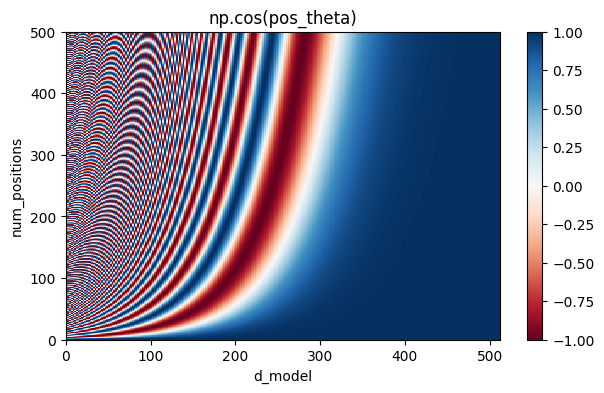

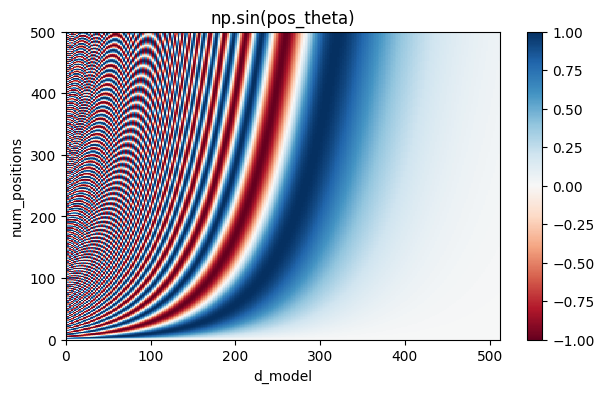

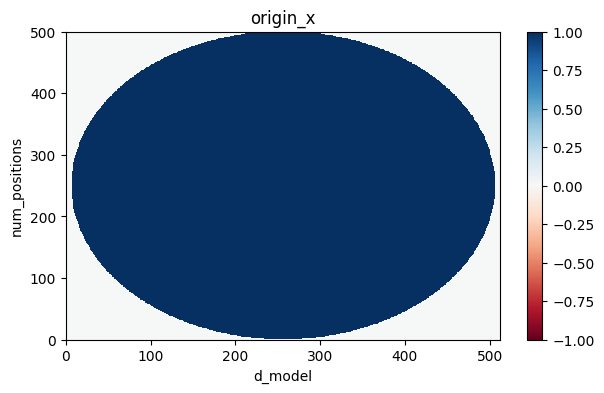

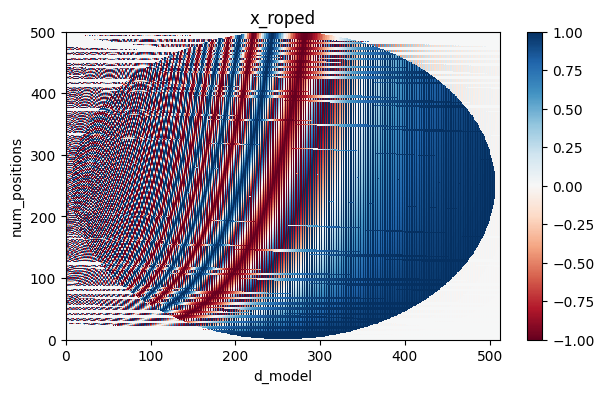

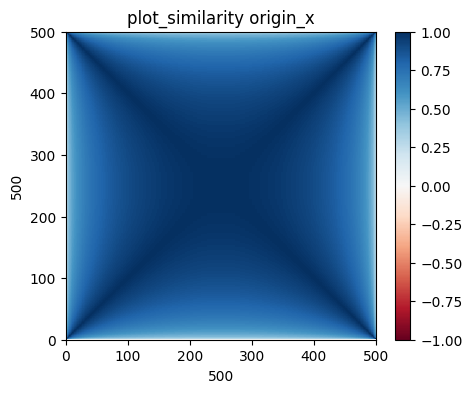

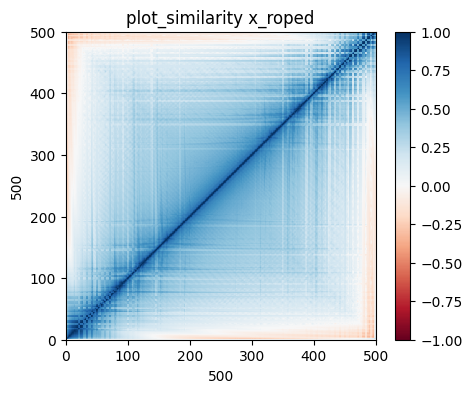

In [10]:

# print(positions, positions.shape)
# print(theta_is, theta_is.shape)

pos_theta = positions * theta_is
# print(pos_theta, pos_theta.shape)


x_1 = origin_x * np.cos(pos_theta)
x_2 = neg_swaped_x(origin_x) * np.sin(pos_theta)
x_roped = x_1 + x_2

plot(np.cos(pos_theta), 'np.cos(pos_theta)')
plot(np.sin(pos_theta), 'np.sin(pos_theta)')

print('origin_x norm', np.linalg.norm(origin_x,axis=1))
print('origin_x x_roped', np.linalg.norm(x_roped,axis=1))

plot(origin_x, 'origin_x')
plot(x_roped, 'x_roped')
plot_similarity(origin_x, 'origin_x')
plot_similarity(x_roped, 'x_roped')









* Changes the Norm length?        Sinusoidal 2x; RoPE 1x;
* Changes visually?            Sinusoidal YES; RoPE YES and NO(for pure random nosie)
* Change the similarity of adjacent? Sinusoidal increase; RoPE decrease
